In [458]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [53]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt','next_complete_dt'],
                 usecols=lambda col: col not in ['d_vlt'])

In [70]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [125]:
o0['IS_over_mean_56'] = (o0['initial_stock_overall'] / o0['mean_56']).replace(np.inf, 0).fillna(0)
o0['overall_opt_order_for_opt'] = o0['overall_opt_order'].copy()

In [126]:
o1 = o0.copy()

In [127]:
# o1.insert(1, 'sku_id', o1['item_sku_id'])
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [128]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [129]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.9, test_size=0.1)

In [410]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 'brand_code', 
    'create_day_of_week'
    ]

VLT_FEA = [
           'review_period', 
    'uprc', 'contract_stk_prc', 
#     'wt', 'width', 'height', 'calc_volume', 'len',
#     'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
#     'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
#     'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
#     'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
#     'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
#     'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
#     'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
#     'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
#         'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
#         'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
#         'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
#         'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
#         'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
#         'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
#         'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
#         'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
#         'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
#         'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
#         'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
#         'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
#            'review_period', 
#            'normal', 
#            'gamma', 
#             'eq'
            ]

IS_FEA = [
#            'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']    
LABEL = ['demand_RV']    

feature_list =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA

# o0[VLT_CAT_FEA_COLS] = o0[VLT_CAT_FEA_COLS].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

# o1 = pd.concat([df_vlt_fea, pd.get_dummies(df_vlt_fea[VLT_CAT_FEA_COLS])], axis=1)
# o2.drop(VLT_CAT_FEA_COLS, axis=1, inplace=True)

In [411]:
low_qtl = o1[feature_list+LABEL].quantile(0.01)
hgh_qtl = o1[feature_list+LABEL].quantile(0.98)
o2 = o1.copy()
o2.loc[:, feature_list+LABEL] = o1[feature_list+LABEL].clip(low_qtl, hgh_qtl, axis=1)

In [412]:
df_train = o2[o2['sku_id'].isin(sku_train)]
df_test = o2[o2['sku_id'].isin(sku_test)]

X_train_ns, y_train_ns, id_train = df_train[feature_list], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[feature_list], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [413]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

23.727653192383485 26.426782206006173


In [414]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [415]:
# mean = X_train_ns.mean(axis=0)
# std = X_train_ns.std(axis=0)
# X_train = (X_train_ns - mean) / std
# X_test = (X_test_ns - mean) / std

In [416]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[120,150], [80,90], 100, 10]

output_dim = 1
q = 0.8


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    
with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2_vlt'):
    W2_vlt = tf.Variable(tf.truncated_normal([hidden_dim[0][0], hidden_dim[1][0]], stddev=0.001), name='Weight_2_vlt')
    b2_vlt = tf.Variable(tf.zeros([hidden_dim[1][0]]), name='Bias_2_vlt')
    l2_vlt = tf.add(tf.matmul(l1_vlt, W2_vlt), b2_vlt)
    l2_vlt = tf.nn.relu(l2_vlt)

with tf.variable_scope('Layer_2_sf'):
    W2_sf = tf.Variable(tf.truncated_normal([hidden_dim[0][1], hidden_dim[1][1]], stddev=0.001), name='Weight_2_sf')
    b2_sf = tf.Variable(tf.zeros([hidden_dim[1][1]]), name='Bias_2_sf')
    l2_sf = tf.add(tf.matmul(l1_sf, W2_sf), b2_sf)
    l2_sf = tf.nn.relu(l2_sf)


with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1][0]+hidden_dim[1][1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2_vlt, l2_sf], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_4'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+oth_dim, hidden_dim[3]], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([hidden_dim[3]]), name='Bias_4')
    l4 = tf.add(tf.matmul(tf.concat([l3, x_oth], axis=1), W4), b4)
    l4 = tf.nn.relu(l4)

with tf.variable_scope('Layer_final'):
    W5 = tf.Variable(tf.truncated_normal([hidden_dim[3]+is_dim,1], stddev=0.001), name='Weight_5')
    b5 = tf.Variable(tf.zeros([1]), name='Bias_5')
    output = tf.add(tf.matmul(tf.concat([l4, x_is], axis=1), W5), b5)
    error = y - output
    loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [417]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[20,25], 30, 10]

output_dim = 1
q = 0.9


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1], hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1]+oth_dim, hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2, x_oth], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error)) 

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [418]:
epochs = 20
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.07878549 0.088504255
1 0.029413127809271397 0.0118541485
2 0.009127040227967008 0.010452616
3 0.008711799096778928 0.010279918
4 0.008535000549172046 0.010151575
5 0.008348177971720215 0.0099912975
6 0.008150231689849883 0.009831419
7 0.007940145708687585 0.00965201
8 0.007728976322860894 0.009469973
9 0.007516132194925388 0.009290709
10 0.007324372826072611 0.009132679
11 0.007140792871729606 0.009004868
12 0.006972663252486383 0.008893261
13 0.00683392561546767 0.008800773
14 0.006723472332386922 0.008696326
15 0.006635998523569649 0.008608285
16 0.006565409845112546 0.008529197
17 0.006507916024992259 0.008486497
18 0.006460172278932012 0.008430232
19 0.006424497555963003 0.008393334
20 0.006396006756710563 0.008360177


In [472]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['prediction']).fillna(0)

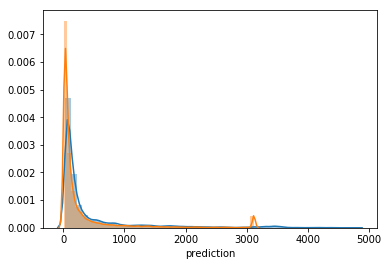

In [355]:
sns.distplot(pred['prediction']);
sns.distplot(y_test_ns);

In [523]:
gbm = lgb.LGBMRegressor(alpha=0.9, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=3600, 
                        subsample=0.7,
                        silent=1,
                        seed=0 )

gbm.fit(X_train, y_train.values.T[0], eval_set=(X_test, y_test.values.T[0])) 

[1]	valid_0's l2: 0.0487298
[2]	valid_0's l2: 0.0445554
[3]	valid_0's l2: 0.0407838
[4]	valid_0's l2: 0.037296
[5]	valid_0's l2: 0.0342154
[6]	valid_0's l2: 0.0315091
[7]	valid_0's l2: 0.0290281
[8]	valid_0's l2: 0.0267606
[9]	valid_0's l2: 0.0247144
[10]	valid_0's l2: 0.0229381
[11]	valid_0's l2: 0.0212733
[12]	valid_0's l2: 0.0197917
[13]	valid_0's l2: 0.018488
[14]	valid_0's l2: 0.0173033
[15]	valid_0's l2: 0.0162497
[16]	valid_0's l2: 0.0152525
[17]	valid_0's l2: 0.0143594
[18]	valid_0's l2: 0.0135593
[19]	valid_0's l2: 0.0128545
[20]	valid_0's l2: 0.0122121
[21]	valid_0's l2: 0.0116159
[22]	valid_0's l2: 0.0110847
[23]	valid_0's l2: 0.0105955
[24]	valid_0's l2: 0.0101682
[25]	valid_0's l2: 0.00977188
[26]	valid_0's l2: 0.00941609
[27]	valid_0's l2: 0.00909467
[28]	valid_0's l2: 0.00880374
[29]	valid_0's l2: 0.00854316
[30]	valid_0's l2: 0.00831055
[31]	valid_0's l2: 0.00810049
[32]	valid_0's l2: 0.00791765
[33]	valid_0's l2: 0.00773881
[34]	valid_0's l2: 0.00758754
[35]	valid_0's 

[278]	valid_0's l2: 0.00617081
[279]	valid_0's l2: 0.00617497
[280]	valid_0's l2: 0.00617365
[281]	valid_0's l2: 0.00617275
[282]	valid_0's l2: 0.00617156
[283]	valid_0's l2: 0.0061722
[284]	valid_0's l2: 0.00617305
[285]	valid_0's l2: 0.00617194
[286]	valid_0's l2: 0.00617294
[287]	valid_0's l2: 0.0061731
[288]	valid_0's l2: 0.0061737
[289]	valid_0's l2: 0.00617478
[290]	valid_0's l2: 0.00617333
[291]	valid_0's l2: 0.00617311
[292]	valid_0's l2: 0.00617157
[293]	valid_0's l2: 0.00617369
[294]	valid_0's l2: 0.00617288
[295]	valid_0's l2: 0.00617189
[296]	valid_0's l2: 0.00617101
[297]	valid_0's l2: 0.00617043
[298]	valid_0's l2: 0.00616804
[299]	valid_0's l2: 0.00616555
[300]	valid_0's l2: 0.0061653
[301]	valid_0's l2: 0.00616259
[302]	valid_0's l2: 0.00616117
[303]	valid_0's l2: 0.00615857
[304]	valid_0's l2: 0.00616196
[305]	valid_0's l2: 0.00616291
[306]	valid_0's l2: 0.00616323
[307]	valid_0's l2: 0.00616223
[308]	valid_0's l2: 0.00616132
[309]	valid_0's l2: 0.00616042
[310]	valid_

[562]	valid_0's l2: 0.00597527
[563]	valid_0's l2: 0.00597633
[564]	valid_0's l2: 0.00597576
[565]	valid_0's l2: 0.00597332
[566]	valid_0's l2: 0.00597358
[567]	valid_0's l2: 0.00597316
[568]	valid_0's l2: 0.00597445
[569]	valid_0's l2: 0.00597381
[570]	valid_0's l2: 0.00597237
[571]	valid_0's l2: 0.00597109
[572]	valid_0's l2: 0.00597179
[573]	valid_0's l2: 0.00597018
[574]	valid_0's l2: 0.00596976
[575]	valid_0's l2: 0.00596884
[576]	valid_0's l2: 0.00596472
[577]	valid_0's l2: 0.00596337
[578]	valid_0's l2: 0.00596138
[579]	valid_0's l2: 0.00596237
[580]	valid_0's l2: 0.0059613
[581]	valid_0's l2: 0.00596008
[582]	valid_0's l2: 0.00595868
[583]	valid_0's l2: 0.00595733
[584]	valid_0's l2: 0.00595656
[585]	valid_0's l2: 0.00595543
[586]	valid_0's l2: 0.00595345
[587]	valid_0's l2: 0.0059529
[588]	valid_0's l2: 0.0059523
[589]	valid_0's l2: 0.00595007
[590]	valid_0's l2: 0.00594826
[591]	valid_0's l2: 0.00594616
[592]	valid_0's l2: 0.00594459
[593]	valid_0's l2: 0.0059446
[594]	valid_

[839]	valid_0's l2: 0.00576533
[840]	valid_0's l2: 0.00576553
[841]	valid_0's l2: 0.0057644
[842]	valid_0's l2: 0.00576355
[843]	valid_0's l2: 0.0057625
[844]	valid_0's l2: 0.00576209
[845]	valid_0's l2: 0.00576183
[846]	valid_0's l2: 0.00576136
[847]	valid_0's l2: 0.00576092
[848]	valid_0's l2: 0.00576009
[849]	valid_0's l2: 0.0057593
[850]	valid_0's l2: 0.00575881
[851]	valid_0's l2: 0.00575865
[852]	valid_0's l2: 0.00575833
[853]	valid_0's l2: 0.00575718
[854]	valid_0's l2: 0.00575614
[855]	valid_0's l2: 0.00575519
[856]	valid_0's l2: 0.00575474
[857]	valid_0's l2: 0.0057489
[858]	valid_0's l2: 0.00574826
[859]	valid_0's l2: 0.00574663
[860]	valid_0's l2: 0.00574598
[861]	valid_0's l2: 0.00574587
[862]	valid_0's l2: 0.00574583
[863]	valid_0's l2: 0.00574553
[864]	valid_0's l2: 0.00574511
[865]	valid_0's l2: 0.00574384
[866]	valid_0's l2: 0.00574315
[867]	valid_0's l2: 0.00574215
[868]	valid_0's l2: 0.00574172
[869]	valid_0's l2: 0.00574169
[870]	valid_0's l2: 0.00574063
[871]	valid_

[1137]	valid_0's l2: 0.00563842
[1138]	valid_0's l2: 0.00563693
[1139]	valid_0's l2: 0.00563598
[1140]	valid_0's l2: 0.00563509
[1141]	valid_0's l2: 0.00563243
[1142]	valid_0's l2: 0.00563131
[1143]	valid_0's l2: 0.00563256
[1144]	valid_0's l2: 0.0056336
[1145]	valid_0's l2: 0.00563379
[1146]	valid_0's l2: 0.00563291
[1147]	valid_0's l2: 0.00563378
[1148]	valid_0's l2: 0.00563346
[1149]	valid_0's l2: 0.00563392
[1150]	valid_0's l2: 0.00563386
[1151]	valid_0's l2: 0.0056334
[1152]	valid_0's l2: 0.00563346
[1153]	valid_0's l2: 0.00563403
[1154]	valid_0's l2: 0.00563302
[1155]	valid_0's l2: 0.00563282
[1156]	valid_0's l2: 0.00563273
[1157]	valid_0's l2: 0.0056325
[1158]	valid_0's l2: 0.00563212
[1159]	valid_0's l2: 0.00563146
[1160]	valid_0's l2: 0.00563053
[1161]	valid_0's l2: 0.00563035
[1162]	valid_0's l2: 0.00562932
[1163]	valid_0's l2: 0.00562888
[1164]	valid_0's l2: 0.00562769
[1165]	valid_0's l2: 0.00562805
[1166]	valid_0's l2: 0.0056271
[1167]	valid_0's l2: 0.00562692
[1168]	valid

[1408]	valid_0's l2: 0.0055468
[1409]	valid_0's l2: 0.0055466
[1410]	valid_0's l2: 0.00554651
[1411]	valid_0's l2: 0.00554626
[1412]	valid_0's l2: 0.00554597
[1413]	valid_0's l2: 0.00554584
[1414]	valid_0's l2: 0.00554638
[1415]	valid_0's l2: 0.00554627
[1416]	valid_0's l2: 0.0055458
[1417]	valid_0's l2: 0.00554539
[1418]	valid_0's l2: 0.00554599
[1419]	valid_0's l2: 0.00554573
[1420]	valid_0's l2: 0.0055454
[1421]	valid_0's l2: 0.00554552
[1422]	valid_0's l2: 0.00554516
[1423]	valid_0's l2: 0.00554399
[1424]	valid_0's l2: 0.00554355
[1425]	valid_0's l2: 0.00554289
[1426]	valid_0's l2: 0.00554145
[1427]	valid_0's l2: 0.0055404
[1428]	valid_0's l2: 0.00554011
[1429]	valid_0's l2: 0.00553983
[1430]	valid_0's l2: 0.00553963
[1431]	valid_0's l2: 0.00553885
[1432]	valid_0's l2: 0.00553827
[1433]	valid_0's l2: 0.00553822
[1434]	valid_0's l2: 0.00553795
[1435]	valid_0's l2: 0.00553732
[1436]	valid_0's l2: 0.00553723
[1437]	valid_0's l2: 0.00553723
[1438]	valid_0's l2: 0.00553677
[1439]	valid_

[1674]	valid_0's l2: 0.00548368
[1675]	valid_0's l2: 0.00548329
[1676]	valid_0's l2: 0.00548317
[1677]	valid_0's l2: 0.00548305
[1678]	valid_0's l2: 0.00548281
[1679]	valid_0's l2: 0.00548263
[1680]	valid_0's l2: 0.00548232
[1681]	valid_0's l2: 0.005482
[1682]	valid_0's l2: 0.00548163
[1683]	valid_0's l2: 0.00548106
[1684]	valid_0's l2: 0.00548074
[1685]	valid_0's l2: 0.00548039
[1686]	valid_0's l2: 0.00548028
[1687]	valid_0's l2: 0.00548006
[1688]	valid_0's l2: 0.00547969
[1689]	valid_0's l2: 0.00547923
[1690]	valid_0's l2: 0.00547901
[1691]	valid_0's l2: 0.00547855
[1692]	valid_0's l2: 0.00547831
[1693]	valid_0's l2: 0.0054785
[1694]	valid_0's l2: 0.00547823
[1695]	valid_0's l2: 0.00547777
[1696]	valid_0's l2: 0.00547745
[1697]	valid_0's l2: 0.00547731
[1698]	valid_0's l2: 0.00547679
[1699]	valid_0's l2: 0.00547683
[1700]	valid_0's l2: 0.00547668
[1701]	valid_0's l2: 0.00547635
[1702]	valid_0's l2: 0.00547578
[1703]	valid_0's l2: 0.00547577
[1704]	valid_0's l2: 0.0054754
[1705]	valid

[1947]	valid_0's l2: 0.00542341
[1948]	valid_0's l2: 0.00542373
[1949]	valid_0's l2: 0.00542363
[1950]	valid_0's l2: 0.00542362
[1951]	valid_0's l2: 0.00542343
[1952]	valid_0's l2: 0.00542314
[1953]	valid_0's l2: 0.00542275
[1954]	valid_0's l2: 0.00542161
[1955]	valid_0's l2: 0.00542148
[1956]	valid_0's l2: 0.00542094
[1957]	valid_0's l2: 0.00542048
[1958]	valid_0's l2: 0.00542151
[1959]	valid_0's l2: 0.00542145
[1960]	valid_0's l2: 0.00542108
[1961]	valid_0's l2: 0.00542152
[1962]	valid_0's l2: 0.00542189
[1963]	valid_0's l2: 0.00542129
[1964]	valid_0's l2: 0.00542086
[1965]	valid_0's l2: 0.00542031
[1966]	valid_0's l2: 0.00541965
[1967]	valid_0's l2: 0.0054197
[1968]	valid_0's l2: 0.00541953
[1969]	valid_0's l2: 0.00542023
[1970]	valid_0's l2: 0.00542022
[1971]	valid_0's l2: 0.0054202
[1972]	valid_0's l2: 0.00541955
[1973]	valid_0's l2: 0.00541916
[1974]	valid_0's l2: 0.00541972
[1975]	valid_0's l2: 0.00541954
[1976]	valid_0's l2: 0.00541962
[1977]	valid_0's l2: 0.00541933
[1978]	val

[2232]	valid_0's l2: 0.00534658
[2233]	valid_0's l2: 0.00534637
[2234]	valid_0's l2: 0.00534598
[2235]	valid_0's l2: 0.00534586
[2236]	valid_0's l2: 0.00534576
[2237]	valid_0's l2: 0.00534548
[2238]	valid_0's l2: 0.00534544
[2239]	valid_0's l2: 0.00534518
[2240]	valid_0's l2: 0.00534501
[2241]	valid_0's l2: 0.00534487
[2242]	valid_0's l2: 0.00534466
[2243]	valid_0's l2: 0.00534427
[2244]	valid_0's l2: 0.00534379
[2245]	valid_0's l2: 0.00534386
[2246]	valid_0's l2: 0.00534459
[2247]	valid_0's l2: 0.00534415
[2248]	valid_0's l2: 0.00534432
[2249]	valid_0's l2: 0.00534362
[2250]	valid_0's l2: 0.00534322
[2251]	valid_0's l2: 0.00534252
[2252]	valid_0's l2: 0.00534208
[2253]	valid_0's l2: 0.00534181
[2254]	valid_0's l2: 0.00534115
[2255]	valid_0's l2: 0.00534083
[2256]	valid_0's l2: 0.00534035
[2257]	valid_0's l2: 0.00534027
[2258]	valid_0's l2: 0.00534003
[2259]	valid_0's l2: 0.00534001
[2260]	valid_0's l2: 0.0053399
[2261]	valid_0's l2: 0.0053397
[2262]	valid_0's l2: 0.0053395
[2263]	vali

[2494]	valid_0's l2: 0.00530424
[2495]	valid_0's l2: 0.00530401
[2496]	valid_0's l2: 0.00530392
[2497]	valid_0's l2: 0.00530404
[2498]	valid_0's l2: 0.00530397
[2499]	valid_0's l2: 0.00530382
[2500]	valid_0's l2: 0.00530365
[2501]	valid_0's l2: 0.00530341
[2502]	valid_0's l2: 0.00530342
[2503]	valid_0's l2: 0.00530329
[2504]	valid_0's l2: 0.00530309
[2505]	valid_0's l2: 0.00530291
[2506]	valid_0's l2: 0.00530211
[2507]	valid_0's l2: 0.00530244
[2508]	valid_0's l2: 0.00530228
[2509]	valid_0's l2: 0.00530211
[2510]	valid_0's l2: 0.00530186
[2511]	valid_0's l2: 0.00530181
[2512]	valid_0's l2: 0.00530182
[2513]	valid_0's l2: 0.00530157
[2514]	valid_0's l2: 0.0053012
[2515]	valid_0's l2: 0.00530098
[2516]	valid_0's l2: 0.00530092
[2517]	valid_0's l2: 0.00530083
[2518]	valid_0's l2: 0.00529909
[2519]	valid_0's l2: 0.00529943
[2520]	valid_0's l2: 0.00529921
[2521]	valid_0's l2: 0.00529965
[2522]	valid_0's l2: 0.00529963
[2523]	valid_0's l2: 0.00529911
[2524]	valid_0's l2: 0.00529871
[2525]	va

[2756]	valid_0's l2: 0.00526405
[2757]	valid_0's l2: 0.00526394
[2758]	valid_0's l2: 0.00526357
[2759]	valid_0's l2: 0.00526352
[2760]	valid_0's l2: 0.00526297
[2761]	valid_0's l2: 0.00526321
[2762]	valid_0's l2: 0.00526281
[2763]	valid_0's l2: 0.00526248
[2764]	valid_0's l2: 0.00526213
[2765]	valid_0's l2: 0.00526195
[2766]	valid_0's l2: 0.00526137
[2767]	valid_0's l2: 0.00526131
[2768]	valid_0's l2: 0.00526212
[2769]	valid_0's l2: 0.00526177
[2770]	valid_0's l2: 0.00526139
[2771]	valid_0's l2: 0.00526113
[2772]	valid_0's l2: 0.00526092
[2773]	valid_0's l2: 0.0052604
[2774]	valid_0's l2: 0.005261
[2775]	valid_0's l2: 0.00526065
[2776]	valid_0's l2: 0.00526043
[2777]	valid_0's l2: 0.00526056
[2778]	valid_0's l2: 0.00526032
[2779]	valid_0's l2: 0.00525979
[2780]	valid_0's l2: 0.00525929
[2781]	valid_0's l2: 0.00525896
[2782]	valid_0's l2: 0.00525869
[2783]	valid_0's l2: 0.00525852
[2784]	valid_0's l2: 0.005258
[2785]	valid_0's l2: 0.00525747
[2786]	valid_0's l2: 0.00525727
[2787]	valid_

[3013]	valid_0's l2: 0.00523445
[3014]	valid_0's l2: 0.00523464
[3015]	valid_0's l2: 0.00523444
[3016]	valid_0's l2: 0.00523411
[3017]	valid_0's l2: 0.00523389
[3018]	valid_0's l2: 0.00523369
[3019]	valid_0's l2: 0.00523343
[3020]	valid_0's l2: 0.00523327
[3021]	valid_0's l2: 0.00523345
[3022]	valid_0's l2: 0.0052333
[3023]	valid_0's l2: 0.00523328
[3024]	valid_0's l2: 0.00523309
[3025]	valid_0's l2: 0.00523288
[3026]	valid_0's l2: 0.00523284
[3027]	valid_0's l2: 0.0052329
[3028]	valid_0's l2: 0.0052327
[3029]	valid_0's l2: 0.00523252
[3030]	valid_0's l2: 0.0052325
[3031]	valid_0's l2: 0.00523233
[3032]	valid_0's l2: 0.0052324
[3033]	valid_0's l2: 0.00523229
[3034]	valid_0's l2: 0.0052323
[3035]	valid_0's l2: 0.00523216
[3036]	valid_0's l2: 0.0052321
[3037]	valid_0's l2: 0.00523196
[3038]	valid_0's l2: 0.00523169
[3039]	valid_0's l2: 0.00523193
[3040]	valid_0's l2: 0.00523172
[3041]	valid_0's l2: 0.00523168
[3042]	valid_0's l2: 0.00523184
[3043]	valid_0's l2: 0.00523183
[3044]	valid_0'

[3283]	valid_0's l2: 0.00519717
[3284]	valid_0's l2: 0.0051969
[3285]	valid_0's l2: 0.00519759
[3286]	valid_0's l2: 0.00519732
[3287]	valid_0's l2: 0.00519719
[3288]	valid_0's l2: 0.00519708
[3289]	valid_0's l2: 0.00519677
[3290]	valid_0's l2: 0.00519641
[3291]	valid_0's l2: 0.00519634
[3292]	valid_0's l2: 0.00519616
[3293]	valid_0's l2: 0.00519604
[3294]	valid_0's l2: 0.00519593
[3295]	valid_0's l2: 0.00519559
[3296]	valid_0's l2: 0.00519559
[3297]	valid_0's l2: 0.00519553
[3298]	valid_0's l2: 0.00519541
[3299]	valid_0's l2: 0.00519543
[3300]	valid_0's l2: 0.00519516
[3301]	valid_0's l2: 0.00519527
[3302]	valid_0's l2: 0.00519493
[3303]	valid_0's l2: 0.00519485
[3304]	valid_0's l2: 0.00519488
[3305]	valid_0's l2: 0.00519465
[3306]	valid_0's l2: 0.00519451
[3307]	valid_0's l2: 0.00519424
[3308]	valid_0's l2: 0.0051932
[3309]	valid_0's l2: 0.00519335
[3310]	valid_0's l2: 0.00519304
[3311]	valid_0's l2: 0.00519278
[3312]	valid_0's l2: 0.00519299
[3313]	valid_0's l2: 0.00519277
[3314]	val

[3545]	valid_0's l2: 0.00516332
[3546]	valid_0's l2: 0.00516306
[3547]	valid_0's l2: 0.00516322
[3548]	valid_0's l2: 0.00516349
[3549]	valid_0's l2: 0.00516334
[3550]	valid_0's l2: 0.00516287
[3551]	valid_0's l2: 0.00516249
[3552]	valid_0's l2: 0.00516242
[3553]	valid_0's l2: 0.00516227
[3554]	valid_0's l2: 0.00516216
[3555]	valid_0's l2: 0.00516196
[3556]	valid_0's l2: 0.00516181
[3557]	valid_0's l2: 0.00516167
[3558]	valid_0's l2: 0.00516148
[3559]	valid_0's l2: 0.00516134
[3560]	valid_0's l2: 0.00516123
[3561]	valid_0's l2: 0.00516102
[3562]	valid_0's l2: 0.00516095
[3563]	valid_0's l2: 0.005161
[3564]	valid_0's l2: 0.00516167
[3565]	valid_0's l2: 0.00516159
[3566]	valid_0's l2: 0.00516165
[3567]	valid_0's l2: 0.00516137
[3568]	valid_0's l2: 0.00516106
[3569]	valid_0's l2: 0.00516074
[3570]	valid_0's l2: 0.00516107
[3571]	valid_0's l2: 0.00516091
[3572]	valid_0's l2: 0.00516062
[3573]	valid_0's l2: 0.00516025
[3574]	valid_0's l2: 0.00516006
[3575]	valid_0's l2: 0.00515988
[3576]	val

LGBMRegressor(alpha=0.9, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-10,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3600, n_jobs=-1, num_leaves=31, objective='quantile',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=0, silent=1,
       subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [524]:
gbm_pred=gbm.predict(X_test) 

In [525]:
gbm_pred = pd.DataFrame(y_scaler.inverse_transform(gbm_pred.reshape(-1, 1)), columns=['prediction']).fillna(0)

In [356]:
h = 1
b = 9

In [502]:
o4 = df_test.copy()
o4.reset_index(drop=True, inplace=True)


In [503]:
o4['actual_pur_qtty'];
o4['overall_opt_order_for_opt'];

In [504]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

In [505]:
o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [506]:
list_c = ['SKU_DC', 'create_tm', 'OPT', 'End2End', 'GBM', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
numberOfRows = len(o4)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

In [507]:
df_cost['SKU_DC']=df_holding['SKU_DC']=df_back['SKU_DC']=df_stockout['SKU_DC']=df_turnover['SKU_DC']=o4['item_sku_id'].values
df_cost['create_tm']=df_holding['create_tm']=df_back['create_tm']=df_stockout['create_tm']=df_turnover['create_tm']=o4['create_tm'].values
df_cost['Ave_sales']=df_holding['Ave_sales']=df_back['Ave_sales']=df_stockout['Ave_sales']=df_turnover['Ave_sales']=o4['mean_112'].values
df_cost['Std_sales']=df_holding['Std_sales']=df_back['Std_sales']=df_stockout['Std_sales']=df_turnover['Std_sales']=o4['std_140'].values

In [508]:
o4['OPT_inv'] = o4.apply(lambda x: [x['overall_opt_order_for_opt']+x['initial_stock_overall']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)

In [528]:
o4['nn_pred'] = pred['prediction'] - o4['initial_stock_overall']
o4['End2End_inv'] = o4.apply(lambda x: [x['nn_pred']+x['initial_stock_overall']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)
o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')
o4['EQ_inv'] = o4.apply(lambda x: [x['EQ_replen_with_IS']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)
Z90 = 1.2816
o4['Normal_replen_with_IS'] = o4.apply(lambda x: int(x['mean_112']*(x['review_period']+x['vendor_vlt_mean'])
                                       +Z90*np.sqrt((x['review_period']+x['vendor_vlt_mean'])*x['std_140']**2
                                                    + x['std_140']**2 * x['vlt_std'])), axis=1)

o4['Normal_inv'] = o4.apply(lambda x: [x['Normal_replen_with_IS']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)

def gamma_base(x):
    mean = x['mean_112']
    var = x['std_140']**2
    theta = var/(mean+1e-5)
    k = mean/(theta+1e-5)
    k_sum = int(x['review_period']+x['vendor_vlt_mean'])*k
    gamma_stock = gamma.ppf(0.9, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        return int(gamma_stock)

o4['Gamma_replen_with_IS'] = o4.apply(gamma_base, axis=1)

o4['Gamma_inv'] = o4.apply(lambda x: [x['Gamma_replen_with_IS']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)

o4['Hist_inv'] = o4.apply(lambda x: [x['actual_pur_qtty']+x['initial_stock']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)

o4['gbm_pred'] = gbm_pred['prediction'] - o4['initial_stock_overall']
o4['GBM_inv'] = o4.apply(lambda x: [x['gbm_pred']+x['initial_stock_overall']-sl
                                        for sl in x['demand_RV_list_acm']], axis=1)

In [488]:
# o4['demand_EQ_list'] = o4.apply(lambda x: df_sl.iloc[:,360:].loc[x['item_sku_id'], \
#                                             :x['create_tm'].date()].values\
#                             if x['item_sku_id'] in df_sl.index else [], axis=1)
# o4['EQ_replen_with_IS'] = o4.apply(lambda x: np.percentile(
#                             [np.sum(x['demand_EQ_list'][i:i+int(x['review_period']+x['vendor_vlt_mean'])])
#                                      for i in range(int(len(x['demand_EQ_list'])-x['review_period']-x['vendor_vlt_mean']))
#                             ], 90), axis=1)
# o4['EQ_replen_with_IS'].to_csv('EQ_replen_with_IS.csv', index=False)
o4['EQ_replen_with_IS'] = pd.read_csv('EQ_replen_with_IS.csv')


In [529]:
str_list = ['OPT', 'End2End', 'GBM', 'EQ', 'Normal', 'Gamma', 'Hist']
for str1 in str_list:
    str2 = str1 + '_inv'
    df_holding[str1] = o4[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df_back[str1] = o4[str2].apply(lambda x: b * sum([-inv for inv in x if inv<0]) )
    df_stockout[str1] = o4[str2].apply(lambda x: len([inv for inv in x if inv<=0])/len(x) )
    df_turnover[str1] = o4.apply(lambda x: np.mean(x[str2]) / np.mean(x['demand_RV_list'])
                                  if np.mean(x['demand_RV_list']) >0 else np.mean(x[str2]), axis=1)
    df_cost[str1] = df_holding[str1] + df_back[str1]

In [530]:
pd.DataFrame({'Best': df_cost.iloc[:,3:9].idxmin(axis=1).value_counts()/len(df_cost)}).T

,Hist,GBM,Gamma,EQ,Normal,End2End
Best,0.303127,0.18705,0.170514,0.159463,0.095612,0.084234


In [531]:
pd.DataFrame({'Total': df_cost[['OPT','End2End','GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','End2End','GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','End2End','GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','End2End','GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','End2End','GBM','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,End2End,GBM,EQ,Normal,Gamma,Hist,Ave_sales
Total,2811.721349,6920.132276,6994.017677,10531.679052,6924.319172,6976.440079,7234.982973,24.441725
Holding,2346.712508,3592.599415,2884.778179,5651.275663,4071.009741,3863.450147,4105.920350,24.441725
Back,465.008841,3327.532860,4109.239499,4880.403389,2853.309430,3112.989931,3129.062623,24.441725
Stockout,0.190946,0.033191,0.049577,0.145292,0.069209,0.079967,0.170872,24.441725
Turnover,7.244524,42.226409,23.088228,111.830176,25.573148,24.568570,17.912668,24.441725


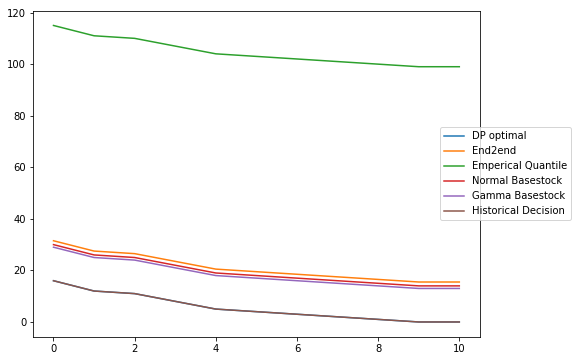

In [424]:
tt = o4.iloc[1100,:]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(tt['OPT_inv'], label = 'DP optimal')
ax1.plot(tt['E2E_inv'], label = 'End2end')
ax1.plot(tt['EQ_inv'], label = 'Emperical Quantile')
ax1.plot(tt['Normal_inv'], label = 'Normal Basestock')
ax1.plot(tt['Gamma_inv'], label = 'Gamma Basestock')
ax1.plot(tt['hist_inv'], label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))

In [425]:
df_cost.sort_values('OPT')

,SKU_DC,create_tm,OPT,End2End,EQ,Normal,Gamma,Hist,Ave_sales,Std_sales
1700,1225986#316,2018-08-20 04:58:10,0.0,2.726365e+02,252.0,96.0,96.0,180.0,0.223214,0.748105
1349,1123686#5,2018-07-10 05:08:36,0.0,5.967233e+03,530.0,1007.0,1060.0,636.0,0.232143,1.179017
790,919987#316,2018-08-20 04:58:40,0.0,3.672426e+02,1692.0,108.0,108.0,360.0,0.276786,0.810897
10130,5363870#9,2018-08-22 19:27:02,0.0,2.403552e+02,120.0,100.0,90.0,240.0,0.214286,1.144696
5382,2686537#5,2018-08-15 16:58:35,0.0,5.701427e+02,952.0,221.0,204.0,204.0,0.357143,0.883182
11476,5917236#3,2018-07-30 05:09:43,0.0,2.044774e+02,0.0,45.0,45.0,54.0,0.214286,0.889126
8266,4369316#772,2018-08-13 05:14:14,0.0,7.046483e+02,36996.8,285.0,304.0,304.0,0.446429,1.150450
4329,2290381#4,2018-08-13 05:14:14,0.0,7.396104e+02,2470.0,152.0,152.0,380.0,0.205357,0.552440
393,838568#9,2018-07-23 05:03:23,0.0,5.143500e+03,1152.0,920.0,920.0,480.0,0.348214,0.873823
9436,4876407#5,2018-08-15 05:00:16,0.0,4.763813e+02,255.0,204.0,204.0,153.0,0.366071,0.700169


In [453]:
co_qtl = df_cost.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
hd_qtl = df_holding.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)
bk_qtl = df_back.iloc[:,2:].quantile(np.linspace(0, 1, 11), numeric_only=False)

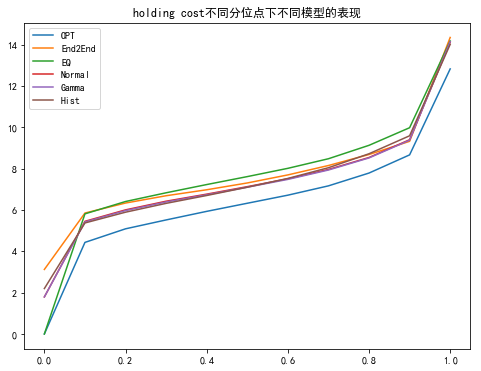

In [454]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(co_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(co_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

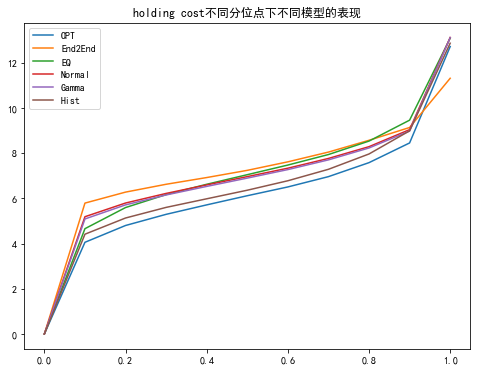

In [455]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(hd_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(hd_qtl.columns[:-2], loc=0)
ax.set_title('holding cost不同分位点下不同模型的表现');

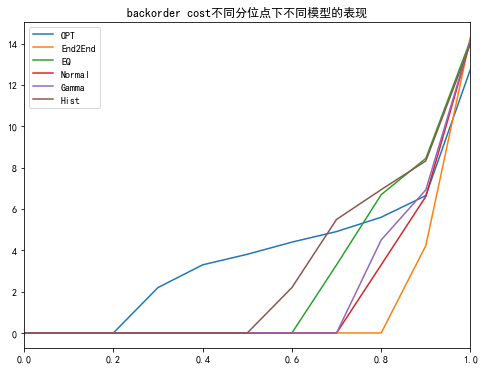

In [456]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.log(bk_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.set_xlim(0, 1)
ax.legend(bk_qtl.columns[:-2], loc=0)
ax.set_title('backorder cost不同分位点下不同模型的表现');

In [ ]:
sess.close()